# House Prices: End-to-End Regression Pipeline

This notebook presents a complete machine learning workflow for predicting
residential property sale prices using structured tabular data.

The solution covers exploratory data analysis, preprocessing, feature engineering,
modeling, evaluation, and ensembling using scikit-learn pipelines.


## 1. Problem Statement

The objective is to predict the final sale price of residential homes based on a
mix of numerical and categorical features describing their properties.

This is a supervised regression problem evaluated using **Root Mean Squared Log Error (RMSLE)**,
which penalizes relative prediction errors and motivates training in log-transformed space.


## 2. Imports and Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error


## 3. Data Loading

The dataset consists of:
- `train.csv`: training data with features and target (`SalePrice`)
- `test.csv`: test data without target values

The data is loaded from local files using relative paths to ensure portability.


In [2]:
housing_train = pd.read_csv("house-prices-data/train.csv")
housing_test = pd.read_csv("house-prices-data/test.csv")

housing_train.shape, housing_test.shape


((1460, 81), (1459, 80))

## 4. Exploratory Data Analysis (EDA)

Before modeling, we explore the dataset to understand:
- The distribution of the target variable
- Feature types (numerical vs categorical)
- Presence of missing values
- Key relationships between features and the target


### 4.1 Dataset overview

In [3]:
housing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 4.2 Target distribution

In [4]:
housing_train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

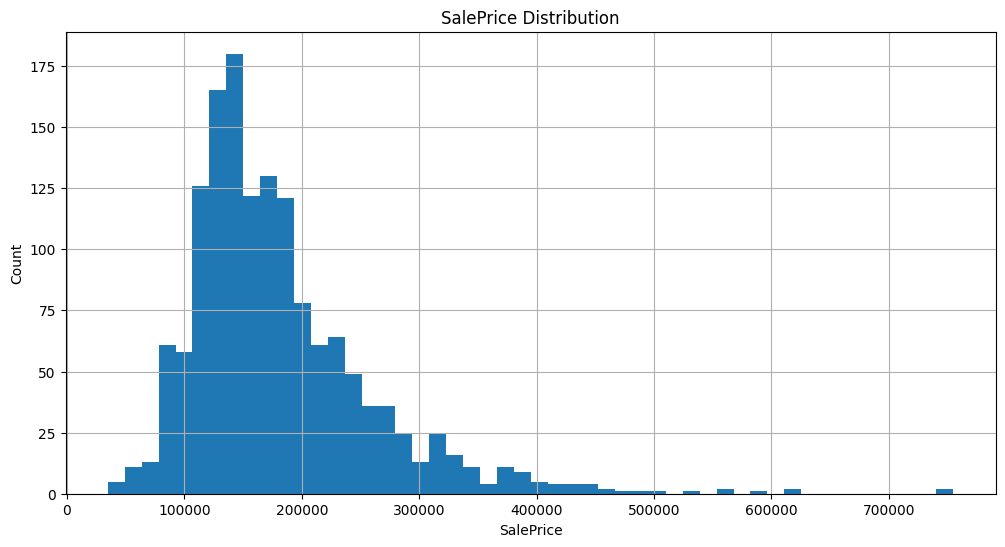

In [5]:
housing_train["SalePrice"].hist(bins=50, figsize=(12, 6))
plt.title("SalePrice Distribution")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.show()


### 4.3 Missing values (training set)

In [6]:
missing = housing_train.isnull().sum()
missing[missing > 0].sort_values(ascending=False).head(30)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64

### 4.4 Feature relationship example

We inspect relationships between important features (e.g., living area) and sale price
to identify trends and potential outliers.


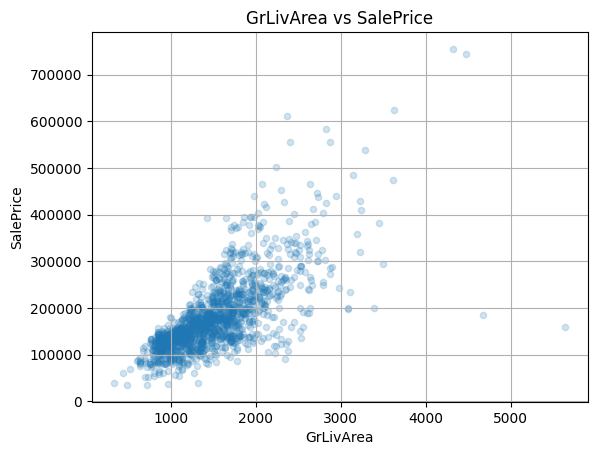

In [7]:
housing_train.plot(kind="scatter", x="GrLivArea", y="SalePrice", grid=True, alpha=0.2)
plt.title("GrLivArea vs SalePrice")
plt.show()

## 5. Feature Engineering

To incorporate domain knowledge and simplify learning, we add engineered features that capture
important real-world relationships more directly.


### 5.1 Engineered Features

- `TotalSF`: total living area across basement + floors
- `HouseAge`: age of the house at time of sale
- `RemodAge`: years since last remodel
- `HasGarage`: binary indicator for garage presence
- `HasBasement`: binary indicator for basement presence


In [8]:
for df in [housing_train, housing_test]:
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    # fillna(0) makes the boolean checks robust even before imputation
    df["HasGarage"] = (df["GarageCars"].fillna(0) > 0).astype(int)
    df["HasBasement"] = (df["TotalBsmtSF"].fillna(0) > 0).astype(int)

housing_train[["TotalSF","HouseAge","RemodAge","HasGarage","HasBasement"]].head()


,TotalSF,HouseAge,RemodAge,HasGarage,HasBasement
0,2566,5,5,1,1
1,2524,31,31,1,1
2,2706,7,6,1,1
3,2473,91,36,1,1
4,3343,8,8,1,1


## 6. Preprocessing Pipeline

We use scikit-learn Pipelines and `ColumnTransformer` to:
- handle missing values without leakage
- one-hot encode categorical variables
- keep preprocessing consistent for training and inference


### 6.1 Split features and target

We train in log space using `log1p(SalePrice)` to address target skew and align with RMSLE.


In [9]:
X = housing_train.drop(columns=["SalePrice"])
y = housing_train["SalePrice"]
y_log = np.log1p(y)

X.shape, y.shape


((1460, 85), (1460,))

### 6.2 Missing value strategy

- Numerical columns where missing implies “not present” (garage/basement measures) → fill with 0  
- Remaining numerical columns → fill with median  
- Categorical columns → fill with "None" and one-hot encode


In [10]:
zero_fill_num_cols = [
    "GarageYrBlt", "GarageArea", "GarageCars",
    "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
]

num_cols = X.select_dtypes(include=np.number).columns
median_num_cols = [c for c in num_cols if c not in zero_fill_num_cols]
cat_cols = X.select_dtypes(include="object").columns

numerical_median_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

numerical_zero_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="None")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num_zero", numerical_zero_transformer, zero_fill_num_cols),
        ("num_median", numerical_median_transformer, median_num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)


## 7. Models

We train three different models (all wrapped in the same preprocessing pipeline):
- Random Forest (non-linear bagging ensemble)
- Gradient Boosting Regressor (boosting)
- Ridge Regression (regularized linear baseline)

Then we ensemble their predictions using a weighted average.


In [11]:
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

gbr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GradientBoostingRegressor(
        n_estimators=600,
        learning_rate=0.03,
        max_depth=3,
        random_state=42
    ))
])

# Note: Ridge doesn't need random_state; keep it simple and portable.
ridge = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=10.0))
])


## 8. Evaluation

We evaluate using RMSE in log space (`log1p(SalePrice)`).
This is consistent with RMSLE-style evaluation and avoids accidentally double-logging the metric.


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

rf.fit(X_train, y_train)
gbr.fit(X_train, y_train)
ridge.fit(X_train, y_train)

pred_rf = rf.predict(X_val)
pred_gbr = gbr.predict(X_val)
pred_ridge = ridge.predict(X_val)

# Weighted average ensemble (weights can be tuned later)
pred_ens = 0.2 * pred_rf + 0.6 * pred_gbr + 0.2 * pred_ridge

rmse_log = np.sqrt(mean_squared_error(y_val, pred_ens))
print("Ensemble Validation RMSE (log space):", rmse_log)


Ensemble Validation RMSE (log space): 0.13169475791964042


## 9. Train Final Models and Generate Submission

We retrain each model on the full training data (log space), generate predictions for the test set,
invert the log transform, and save a file in the expected submission format.


In [13]:
rf.fit(X, y_log)
gbr.fit(X, y_log)
ridge.fit(X, y_log)

test_pred_log = (
    0.2 * rf.predict(housing_test) +
    0.6 * gbr.predict(housing_test) +
    0.2 * ridge.predict(housing_test)
)

predictions = np.expm1(test_pred_log)


## 10. Conclusion and Next Steps

This notebook demonstrates an end-to-end regression workflow:
- EDA and missing value analysis
- Feature engineering
- Leakage-safe preprocessing with `Pipeline` + `ColumnTransformer`
- Model training and validation
- Simple weighted ensembling

Potential next steps:
- Use K-Fold cross-validation for more stable evaluation and fold-averaged predictions
- Try specialized gradient boosting libraries (LightGBM / XGBoost / CatBoost)
- Tune ensemble weights using cross-validation
